1\. **Pandas DataFrame**

This exercise consists in analyzing a dataset containg timing information from a series of Time-to-Digital-Converters (TDC) implemented in a pair of FPGAs. Each measurement (i.e. each row of the input file) consists of a flag that specifies the type of message ('HEAD', which in this case is always 1), two addresses of the TDC providing the signal ('FPGA' and 'TDC_CHANNEL'), and the timing information ('ORBIT_CNT', 'BX_COUNTER', and 'TDC_MEAS'). Each TDC count corresponds to 25/30 ns, whereas a unit of BX_COUNTER corresponds to 25 ns, and the ORBIT_CNT is increased every `x` BX_COUNTER. This allows to store the time in a similar way to hours, minutes and seconds.

In [72]:
# If haven't downloaded it yet, please get the data file with wget
!wget https://www.dropbox.com/s/xvjzaxzz3ysphme/data_000637.txt -P ./data/

--2022-11-21 19:47:41--  https://www.dropbox.com/s/xvjzaxzz3ysphme/data_000637.txt
Resolving www.dropbox.com (www.dropbox.com)... 162.125.69.18
Connecting to www.dropbox.com (www.dropbox.com)|162.125.69.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/xvjzaxzz3ysphme/data_000637.txt [following]
--2022-11-21 19:47:41--  https://www.dropbox.com/s/raw/xvjzaxzz3ysphme/data_000637.txt
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc8ea803f131b2b9901a9e1da568.dl.dropboxusercontent.com/cd/0/inline/BxMAtYyMkllO8LUeQl47nAKIbNzp40-jEXbtVdwz0TLft8IAJnBbDQYNlNTIOejXfpxkKpp-8OO9I0q3_yptV64bxkkj3xz9RAKYqB1vp86jhATxGwinn8TIS9P-J0Yx2HzOA-yKFlydIbL0NPaDdy4I2gNeGSjuvdUm8Bbb9iXexg/file# [following]
--2022-11-21 19:47:42--  https://uc8ea803f131b2b9901a9e1da568.dl.dropboxusercontent.com/cd/0/inline/BxMAtYyMkllO8LUeQl47nAKIbNzp40-jEXbtVdwz0TLft8IAJnBbDQYNlNTIOejXfpxkKpp-8OO9I0q3_yptV64bxkkj3xz9R

1\. Create a Pandas DataFrame reading N rows of the `data/data_000637.txt` dataset. Choose N to be smaller than or equal to the maximum number of rows and larger that 10k (check the documentation).

In [73]:
import pandas as pd # standard naming convention
import numpy as np
file_name = "./data/data_000637.txt"
data = pd.read_csv(file_name)
data
print(data.shape)
#N=np.random.randint(10000,data.shape[0])
N= data.shape[0]
df=pd.DataFrame(data[:N])
df

(1310720, 6)


,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS
0,1,0,123,3869200167,2374,26
1,1,0,124,3869200167,2374,27
2,1,0,63,3869200167,2553,28
3,1,0,64,3869200167,2558,19
4,1,0,64,3869200167,2760,25
...,...,...,...,...,...,...
1310715,1,0,62,3869211171,762,14
1310716,1,1,4,3869211171,763,11
1310717,1,0,64,3869211171,764,0
1310718,1,0,139,3869211171,769,0


2\. Estimate the number of BX in a ORBIT (the value `x`).

*Hint*: check when the BX counter reaches the maximum value before being reset to 0.

In [75]:
x = df.groupby("ORBIT_CNT")["BX_COUNTER"].max()
print('The number of BX in a ORBIT is : \n',x.max())


The number of BX in a ORBIT is : 
 3563


3\. Create a new column with the absolute time in ns (as a combination of the other three columns with timing information) since the beginning of the data acquisition, and convert the new column to a Time Series.

In [78]:
#df.loc[0,'Absolute Time'] = 25/30* df.loc[0,'TDC_MEAS'] + 25*df.loc[0,'BX_COUNTER']  + 3563 *df.loc[0,'BX_COUNTER']*25

tdc_meas = 25/30* (df['TDC_MEAS']-df.loc[0,'TDC_MEAS'])
BX_counter = 25*(df['BX_COUNTER']- df.loc[0,'BX_COUNTER'])
orbit_CNT = 3563*25*(df['ORBIT_CNT'] -df.loc[0,'ORBIT_CNT'])
df['Absolute Time'] = tdc_meas.cumsum() + BX_counter.cumsum() +orbit_CNT.cumsum()

df['Absolute Time'] = pd.to_datetime(df['Absolute Time'], unit="ns")
df

#df.loc['Absolute Time'] =  25/30* df.loc[i,'TDC_MEAS'] + 25*df.loc[i,'BX_COUNTER']  + 3563 *df.loc[i,'BX_COUNTER']*25

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,Absolute Time
0,1,0,123,3869200167,2374,26,1970-01-01 00:00:00.000000000
1,1,0,124,3869200167,2374,27,1970-01-01 00:00:00.000000000
2,1,0,63,3869200167,2553,28,1970-01-01 00:00:00.000004477
3,1,0,64,3869200167,2558,19,1970-01-01 00:00:00.000009071
4,1,0,64,3869200167,2760,25,1970-01-01 00:00:00.000018720
...,...,...,...,...,...,...,...
1310715,1,0,62,3869211171,762,14,1970-01-09 03:23:12.043346506
1310716,1,1,4,3869211171,763,11,1970-01-09 03:23:13.023487519
1310717,1,0,64,3869211171,764,0,1970-01-09 03:23:14.003628547
1310718,1,0,139,3869211171,769,0,1970-01-09 03:23:14.983769700


4\. Find out the duration of the data taking in hours, minutes and seconds, by using the features of the Time Series. Perform this check reading the whole dataset.

In [79]:
print('The duration of the data is : ',df['Absolute Time'][len(df)-1] - df['Absolute Time'][0])

The duration of the data is :  8 days 03:23:15.963910694


5\. Use the `.groupby()` method to find out the noisy channels, i.e. the TDC channels with most counts (print to screen the top 3 and the corresponding counts)

In [80]:
print(df.groupby(['TDC_CHANNEL']).count()['HEAD'].sort_values(ascending = False)[:3])


TDC_CHANNEL
139    108059
64      66020
63      64642
Name: HEAD, dtype: int64


6\. Count the number of non-empty orbits (i.e. the number of orbits with at least one hit).

In [81]:
o =df.groupby(['ORBIT_CNT']).count()# count the number of rows for each values of ORBIT_CNT

print('There is :',len(o.index), 'non-empty orbits')

There is : 11001 non-empty orbits


7\. Count the number of unique orbits with at least one measurement from TDC_CHANNEL=139.

In [82]:
df2 = df[df['TDC_CHANNEL']==139]
o =df2.groupby('ORBIT_CNT').count()
indexes = o.index.tolist()
print(len(indexes))

10976


8\. Create two Series (one for each FPGA) that have the TDC channel as index, and the number of counts for the corresponding TDC channel as values.

In [101]:
import random
sr1 = pd.Series(df[df['FPGA']==0].groupby(['TDC_CHANNEL']).count()['HEAD'], index =df['TDC_CHANNEL'].sort_values()).drop_duplicates()
print('For FPGA = 0: \n',sr1)
sr2 = pd.Series(df[df['FPGA']==1].groupby(['TDC_CHANNEL']).count()['HEAD'], index =df['TDC_CHANNEL'].sort_values()).drop_duplicates()
print('\n\n For FPGA = 1: \n',sr2)

For FPGA = 0: 
 TDC_CHANNEL
1       1215.0
2       1602.0
3       1493.0
4       2352.0
5       1432.0
        ...   
129        2.0
130       33.0
137       32.0
138       34.0
139    75617.0
Name: HEAD, Length: 125, dtype: float64


 For FPGA = 1: 
 TDC_CHANNEL
1      28438.0
2      32669.0
3      21970.0
4      26403.0
5      15003.0
        ...   
128     1454.0
129       35.0
130       38.0
137       36.0
139    32442.0
Name: HEAD, Length: 128, dtype: float64


9\. **Optional:** Create two histograms (one for each FPGA) that show the number of counts for each TDC channel.

Text(0.5, 1.0, 'FPGA = 1')

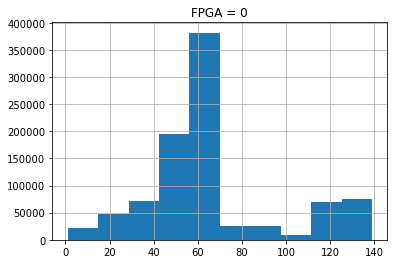

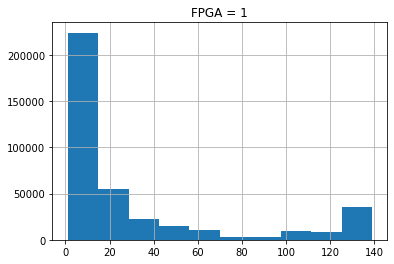

In [143]:

df1 = df[df['FPGA']==0]
histo1 = df1.hist(column = 'TDC_CHANNEL')
plt.title('FPGA = 0')
df2 = df[df['FPGA']==1]
histo1 = df2.hist(column = 'TDC_CHANNEL')
plt.title('FPGA = 1')